In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
plt.rcParams["figure.facecolor"] = "w"
sns.set_style('whitegrid')

### Пример CUPED

In [3]:
users_num = 1000

In [4]:
df = pd.DataFrame()
df['user'] = range(users_num)
df['group'] = np.random.rand(users_num) < 0.5

df['user_mean'] = np.random.uniform(400, 1000, size=users_num)
df['cost_before'] = df['user_mean'] + np.random.normal(0, 50, size=users_num)
df['cost'] = df['user_mean'] + np.random.normal(0, 50, size=users_num)

In [5]:
theta = np.cov(df['cost'], df['cost_before'])[0, 1] / np.var(df['cost_before'])
theta

0.9272612977599674

In [6]:
df['cost_cuped'] = (
    df['cost'] -
    theta * (df['cost_before'] - np.mean(df['cost_before']))
)

In [7]:
np.mean(df[df.group == 0].cost), np.mean(df[df.group == 0].cost_cuped)

(695.1049272086817, 695.8322255986365)

In [8]:
np.var(df[df.group == 0].cost), np.var(df[df.group == 1].cost)

(33906.80385516056, 34233.38266033184)

In [9]:
np.var(df[df.group == 0].cost_cuped), np.var(df[df.group == 1].cost_cuped)

(4940.2242874283675, 4449.8573093173545)

### Измерение кликов

In [10]:
users_num = 1000

mean_user_ctr = 0.2
beta = 20
alpha = mean_user_ctr * beta / (1 - mean_user_ctr)

In [11]:
df = pd.DataFrame()
df['user'] = range(users_num)
df['group'] = np.random.rand(users_num) < 0.5

df['base_user_ctr'] = np.random.beta(alpha, beta, size=users_num)
df['views'] = np.random.lognormal(mean=1, sigma=1, size=users_num).astype(int) + 1
df['clicks'] = np.random.binomial(df['views'], df['base_user_ctr'])

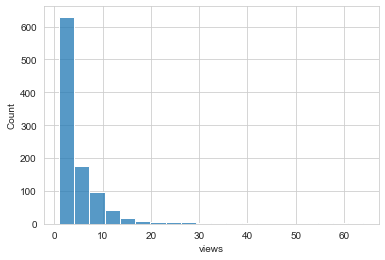

In [12]:
sns.histplot(df.views, bins=20)
plt.show()

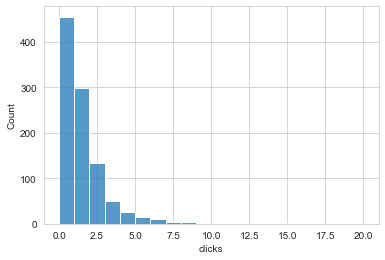

In [13]:
sns.histplot(df.clicks, bins=20)
plt.show()

In [14]:
from scipy.stats import mannwhitneyu

mannwhitneyu(df[df.group == 0].clicks, df[df.group == 1].clicks)

MannwhitneyuResult(statistic=130269.5, pvalue=0.21670073794925337)

### Бутстрэп

In [15]:
n_iter = 1000

data_1 = df[df.group == 0]
data_2 = df[df.group == 1]

stats = []
for _ in range(n_iter):
    sampled_data_1 = data_1.sample(n=len(data_1), replace=True)
    sampled_data_2 = data_2.sample(n=len(data_2), replace=True)

    ctr_1 = sampled_data_1.clicks.sum() / sampled_data_1.views.sum()
    ctr_2 = sampled_data_2.clicks.sum() / sampled_data_2.views.sum()
    stats.append(ctr_1 - ctr_2)

stats = np.array(stats)

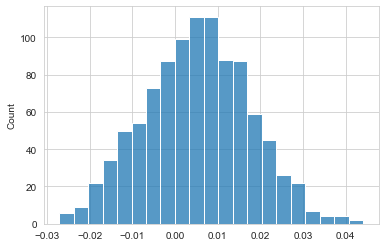

In [16]:
sns.histplot(stats)
plt.show()

In [17]:
2 * min(
    sum(stats <= 0),
    sum(stats >= 0)
) / len(stats)

0.67

### Бакетирование

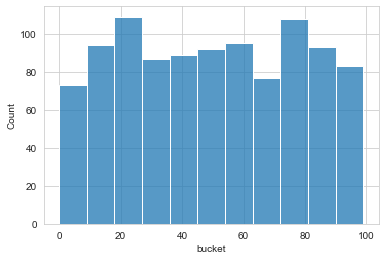

In [18]:
import hashlib

df['bucket'] = df['user'].apply(
    lambda x: int(hashlib.md5((str(x) + 'my_salt').encode()).hexdigest(), 16) % 100
)

sns.histplot(df.bucket)
plt.show()

In [19]:
new_df = df.groupby(['group', 'bucket']).sum(['views', 'ctr']).reset_index()
new_df['ctr'] = new_df.clicks / new_df.views

new_df.head()

,group,bucket,user,base_user_ctr,views,clicks,ctr
0,False,0,2191,1.201540,27,3,0.111111
1,False,1,1747,0.813555,19,6,0.315789
2,False,2,2817,0.687339,34,6,0.176471
3,False,3,1723,1.117524,24,3,0.125000
4,False,4,2926,1.067735,30,9,0.300000


In [20]:
mannwhitneyu(new_df[new_df.group == 0].ctr, new_df[new_df.group == 1].ctr)

MannwhitneyuResult(statistic=5331.0, pvalue=0.3487351178483513)

### Линеаризация

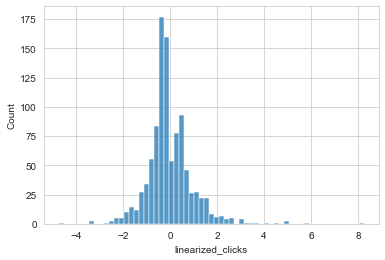

In [21]:
coef = df[df.group == 0].clicks.sum() / df[df.group == 0].views.sum()
df['linearized_clicks'] = df.clicks - coef * df.views

sns.histplot(df['linearized_clicks'])
plt.show()

In [22]:
mannwhitneyu(
    df[df.group == 0].linearized_clicks,
    df[df.group == 1].linearized_clicks
)

MannwhitneyuResult(statistic=126743.0, pvalue=0.6998440693926202)